In [2]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [3]:
# Import data
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

In [4]:
# Available features
list(train)

['OBJECTID',
 'SSL',
 'BATHRM',
 'HF_BATHRM',
 'HEAT',
 'HEAT_D',
 'AC',
 'NUM_UNITS',
 'ROOMS',
 'BEDRM',
 'AYB',
 'YR_RMDL',
 'EYB',
 'STORIES',
 'SALEDATE',
 'QUALIFIED',
 'SALE_NUM',
 'GBA',
 'BLDG_NUM',
 'STYLE',
 'STYLE_D',
 'STRUCT',
 'STRUCT_D',
 'GRADE',
 'GRADE_D',
 'CNDTN',
 'CNDTN_D',
 'EXTWALL',
 'EXTWALL_D',
 'ROOF',
 'ROOF_D',
 'INTWALL',
 'INTWALL_D',
 'KITCHENS',
 'FIREPLACES',
 'USECODE',
 'LANDAREA',
 'GIS_LAST_MOD_DTTM',
 'LN_PRICE']

In [7]:
# Drop all observations where the outcome (LN_PRICE) is missing 
train = train[~train.LN_PRICE.isna()]

# Subsample
train = train.sample(1000,random_state=1988)

# Get new dimensions of the training dataset
train.shape

(1000, 39)

In [10]:
train_y = train['LN_PRICE'] # OUTCOME: log selling price (some houses are ridiculuously expensive)
train_x = train[['BEDRM','LANDAREA']] # PREDICTORS: simplified for our purposes
train_x['LANDAREA'] = np.log(train_x['LANDAREA']) # Log land area (some house are on a lot of land, other on barely a plot)
train_x.shape # Predictor dimensions

(1000, 2)

In [13]:
# Rescaling data for now before it's put into a pipeline
scaler = pp.MinMaxScaler()
col_names = list(train_x)
train_x = scaler.fit_transform(train_x)

# Convert back into data frame
train_x = pd.DataFrame(train_x,columns=col_names)
train_x

,BEDRM,LANDAREA
0,0.428571,0.417960
1,0.285714,0.439156
2,0.428571,0.205976
3,0.285714,0.410843
4,0.571429,0.654388
...,...,...
995,0.285714,0.388141
996,0.285714,0.549782
997,0.142857,0.217015
998,0.428571,0.322339


In [14]:
# Set up k-fold generator to split up data and cross-validate different methods
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# Calculate mean-squared error metric
use_metrics = ["neg_mean_squared_error"]

In [18]:
# Models

# Linear model
lm_scores = cross_validate(LM(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

# K-nearest neighbors model
knn_scores = cross_validate(KNN(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

# Random forest model
rf_scores = cross_validate(RF(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

# Decision tree model
dt_scores = cross_validate(DTree(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

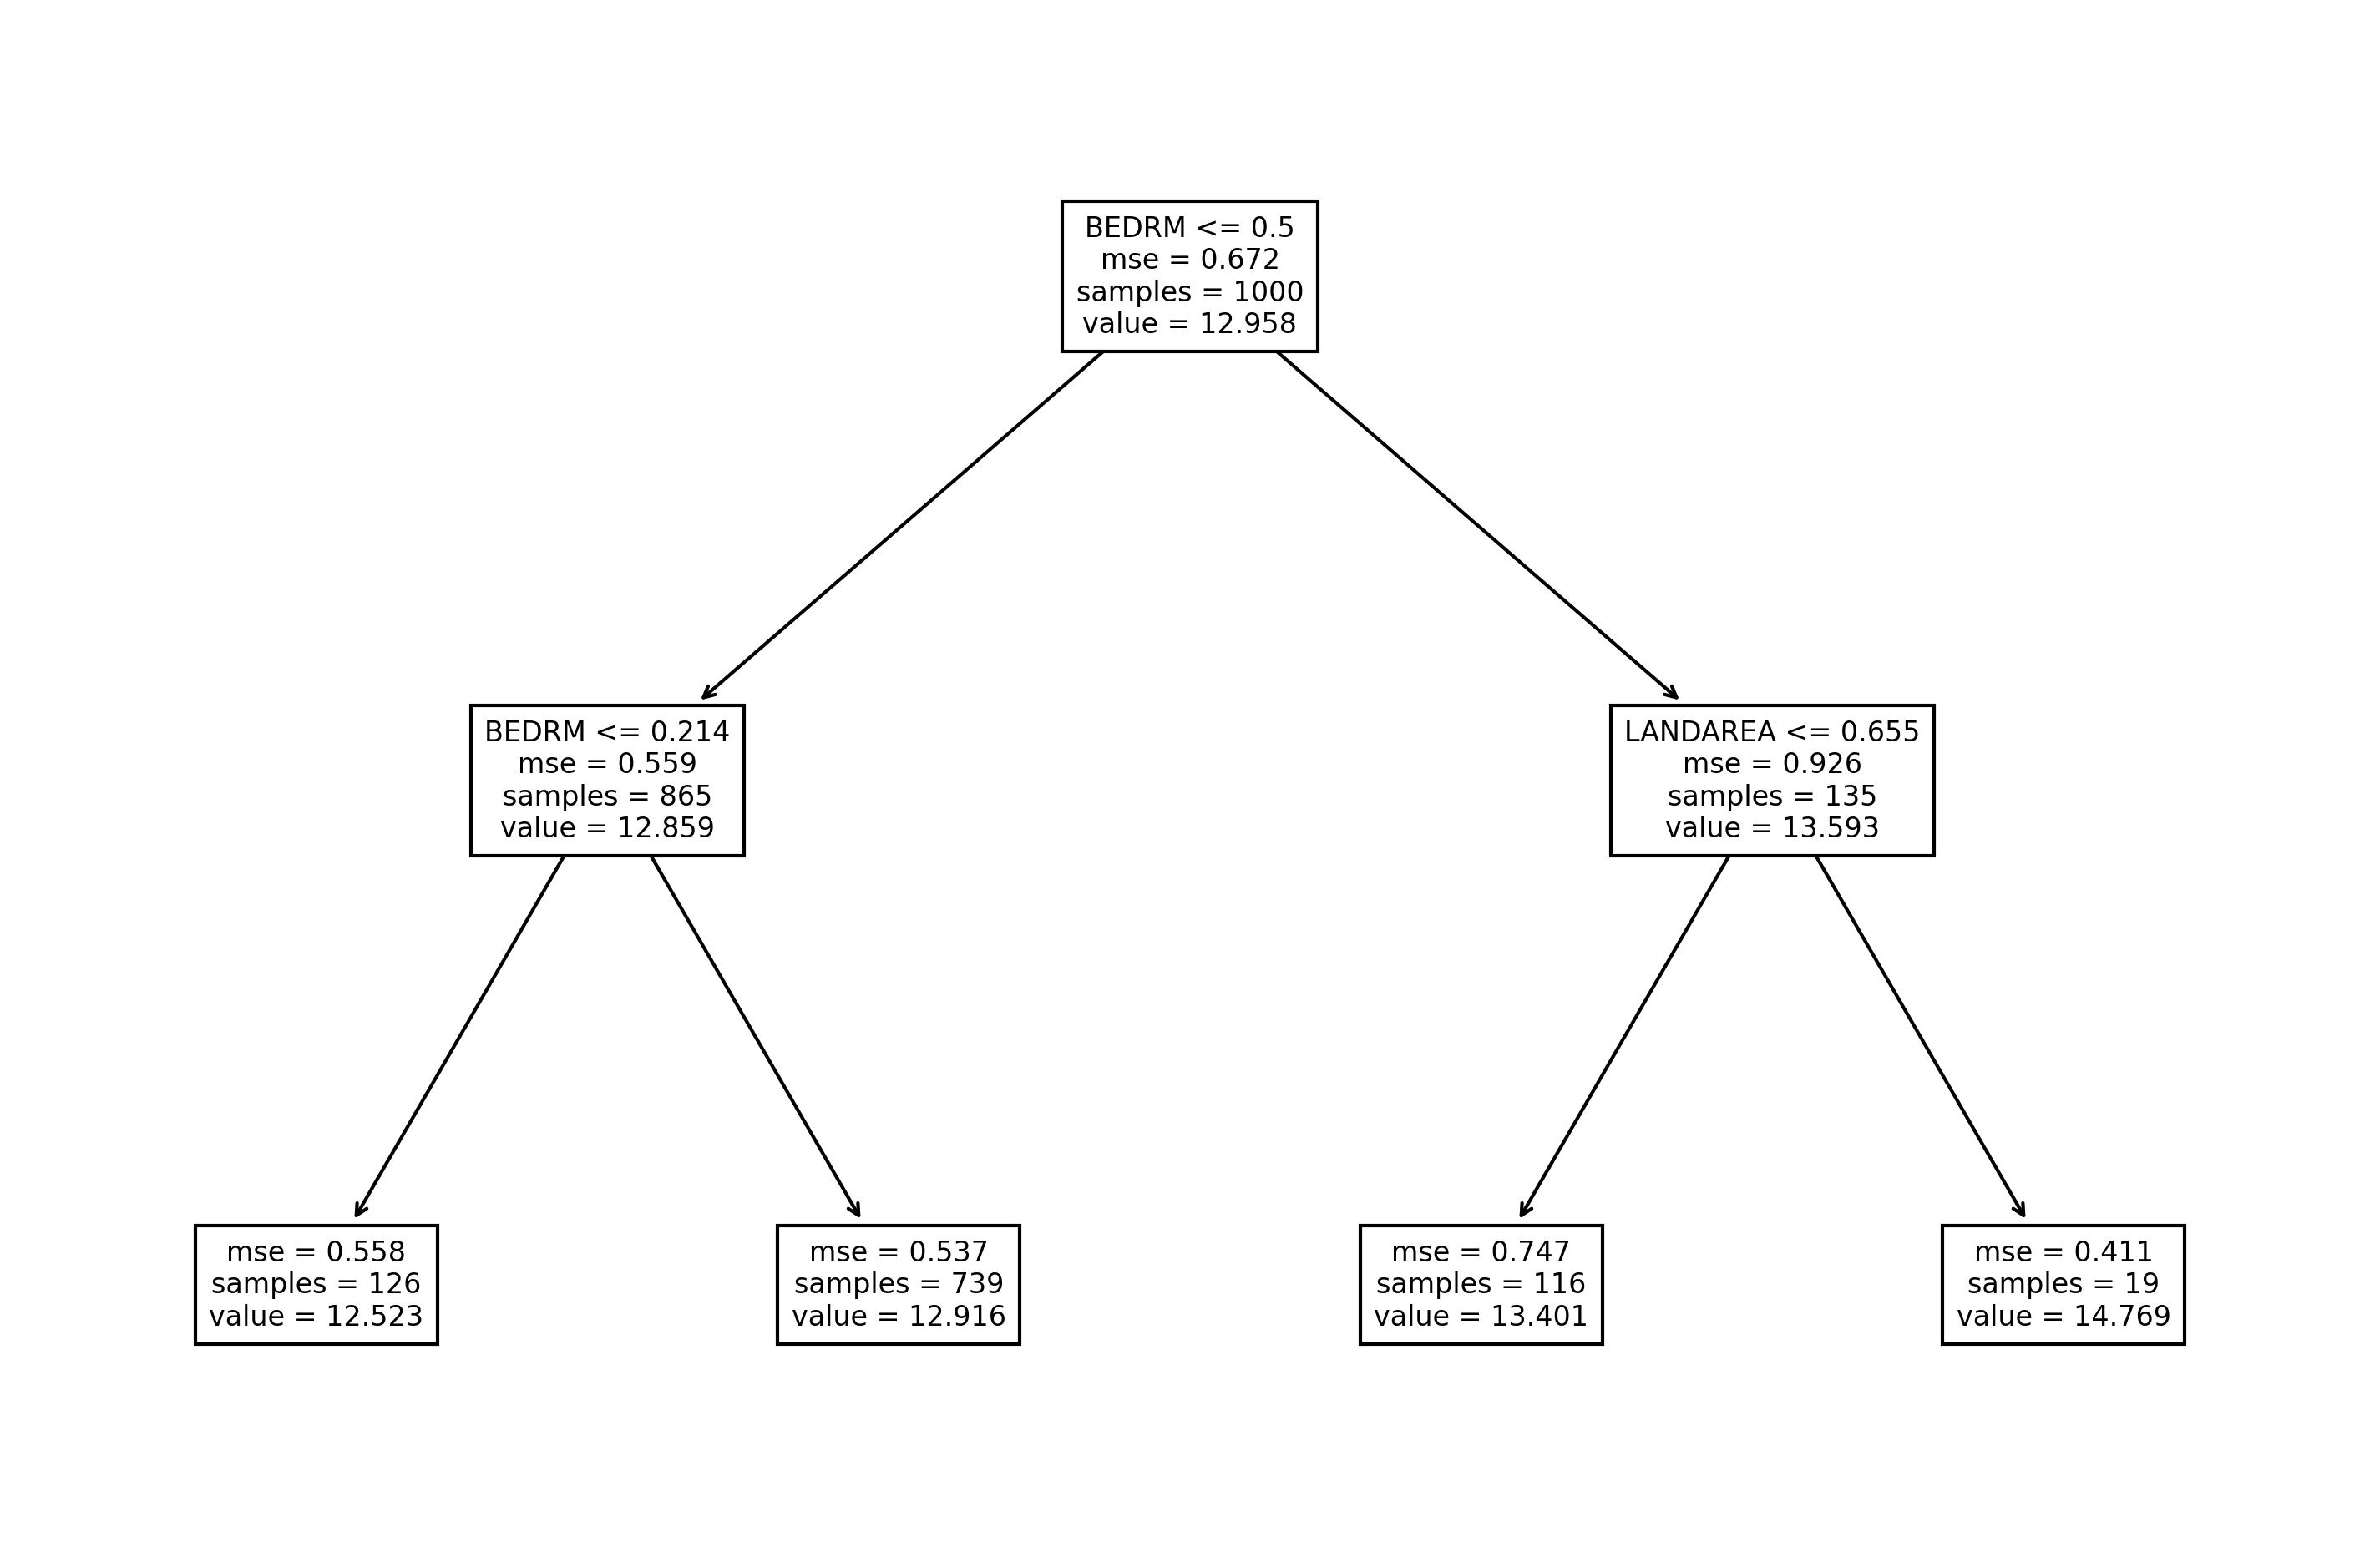

In [20]:
# Show decision tree plot
mod = DTree(max_depth=2) 
mod.fit(train_x,train_y)

plt.figure(figsize=(12,8),dpi=300)
rules = tree.plot_tree(mod,feature_names = col_names,fontsize=8)

In [21]:
# Collect all the metrics we care about as a dictionary to compare the different models
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,0.569378
1,lm,0.584607
2,lm,0.708703
3,lm,0.580854
4,lm,0.552704
5,knn,0.603626
6,knn,0.751373
7,knn,0.735964
8,knn,0.612806
9,knn,0.613199


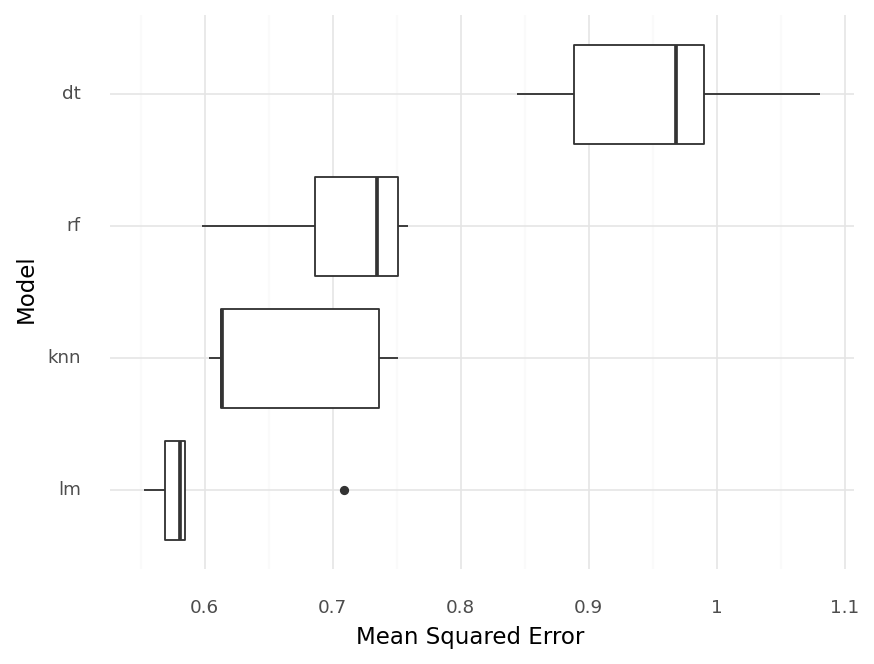

<ggplot: (139922731126)>

In [22]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Create box plot of the MSEs of each model
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

Based on the mean squared errors, it appears as though the OLS model has the best fit when using the log area and number of bedrooms to predict the log price of housing in DC. However, we still have to tune the models.

In [30]:
# Model tuning using a pipeline

# Specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BEDRM','LANDAREA'])])


# Create our model pipe 
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# Specify the models and their repsective tuning parameters.
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# Fit the model to the training data
search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BEDRM',
                                                                          'LANDAREA'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor()],
                          'model__n_neighbors': [10, 15, 20, 25, 30]},
                         {'model': [DecisionTreeRegressor()],
                          'model__max_depth': [1, 2, 3, 5]},
                         {'model': [RandomForestRegressor(max_depth=3,
                                                          n_estimators=

In [32]:
# Find model and parameter with the best fit (lowest MSE)
search.best_params_

{'model': RandomForestRegressor(max_depth=3, n_estimators=1250),
 'model__max_depth': 3,
 'model__n_estimators': 1250}

In [33]:
# Return the score of the best model fit and parameter
# In this case, the random forest model with max_depth = 3 and n_estimators = 1250
search.best_score_

-0.5471510129696715

In [53]:
# Using model to predict test data

# Drop all observations where the outcome (LN_PRICE) is missing in test data
test = test[~test.LN_PRICE.isna()]

# Subsample
test = test.sample(1000,random_state=1988)

In [60]:
# Define test x and test y
test_y = test['LN_PRICE']
test_x = test[['BEDRM','LANDAREA']]
test_x['LANDAREA'] = np.log(test_x['LANDAREA']) # Transforming area into logged variable
test_x = test_x[test_x.LANDAREA > 0] # Only keeping observations with value > 0
test_x = scaler.fit_transform(test_x)
test_x = pd.DataFrame(test_x,columns=col_names)

In [61]:
# Defining our prediction
pred_y = search.predict(test_x)

In [62]:
# Mean squared error for the prediction
m.mean_squared_error(test_y,pred_y)

0.6913520855304235

In [63]:
# R squared value for the prediction
m.r2_score(test_y,pred_y)

0.12332713756375746

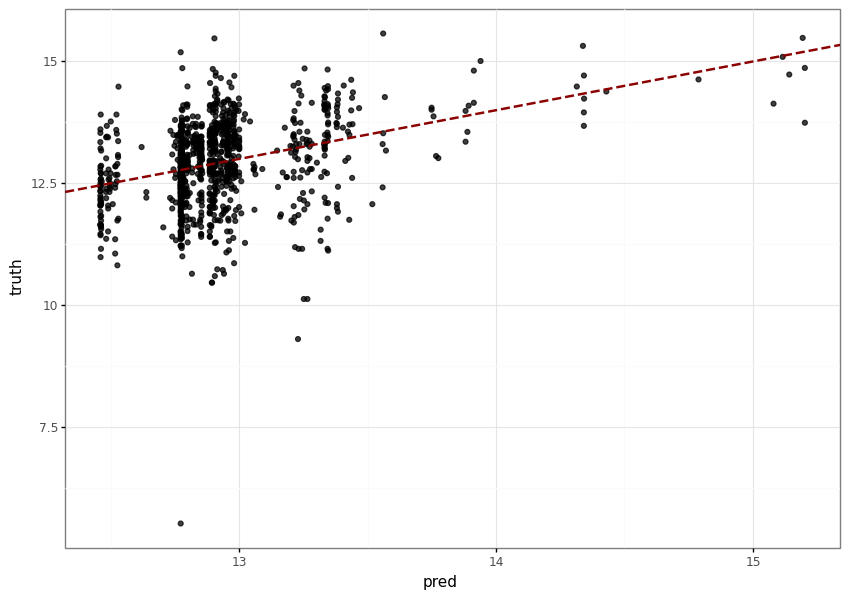

<ggplot: (139922925815)>

In [64]:
# Visualization
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

While the training data gave an MSE of 0.54, the test data gave a larger MSE of 0.69. Given an R-squared of 0.12, this model does not predict the test data very well. So, it's likely that land area and number of bedrooms are not the best predictors of housing prices in DC.